# Deep Convolutional Generative Adversarial Network


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torchvision.utils import make_grid

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data

In [3]:
batch_size= 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5,), std = (0.5,))])

train_set = MNIST('./data/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [4]:
img, _ = next(iter(train_loader))
print(img.shape)

torch.Size([100, 1, 28, 28])


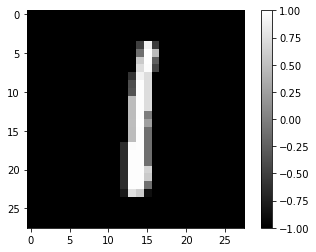

In [5]:
# Example: Normalized image. Values in [-1,1]
shw = plt.imshow(img[0].permute(1,2,0), cmap='gray')
plt.colorbar(shw)
plt.show()

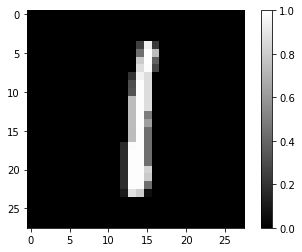

In [6]:
# Example: Denormalized image. Values in [0,1]
def denormalize(x):
    x = (x + 1) / 2
    return x

shw = plt.imshow(denormalize(img[0].permute(1,2,0)), cmap='gray')
plt.colorbar(shw)
plt.show()

## GAN

In [7]:
class Generator(nn.Module):
    def __init__(self, input_channels=64, output_channels=1, hidden_channels=64):
        super().__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(input_channels, hidden_channels * 4, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_channels * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(hidden_channels * 4, hidden_channels * 2 , kernel_size=4, stride=1),
            nn.BatchNorm2d(hidden_channels * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(hidden_channels * 2, hidden_channels, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(hidden_channels, output_channels, kernel_size=4, stride=2),
            nn.Tanh())

    def forward(self, x):
        # x: [batch_size, channels=latent_dimension, width=1, height=1]
        return self.generator(x)
        # [batch_size, channels=1, width=28, height=28]

In [44]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=16):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=4, stride=2),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_channels, hidden_channels * 2, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_channels * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_channels * 2, hidden_channels * 4, kernel_size=4, stride=1),
            nn.BatchNorm2d(hidden_channels * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_channels * 4, 1, kernel_size=3, stride=2))

    def forward(self, x):
        return self.discriminator(x)

In [45]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

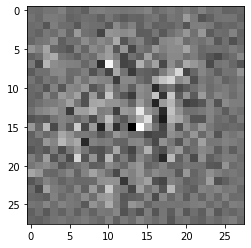

In [54]:
# Testing Generator
generator = Generator(input_channels = 64,  # latent_size
                      output_channels = 1,  # Number of channels of the image
                      hidden_channels = 64).to(device)

generator = generator.apply(init_weights)

noise_vector = noise_vector = torch.randn([1,64,1,1], device=device)
# noise_vector: [batch_size=1, channels=latent_size=64, width=1, height=1]
fake_img = generator(noise_vector)
# fake_img: [batch_size, channels=1, width=28, height=28]
fake_img = denormalize(fake_img.detach().cpu().permute(0, 2, 3, 1))
plt.imshow(fake_img[0], cmap='gray')
plt.show()

## Training

In [60]:
#Parameters and hyperparameters
epochs = 2
latent_size = 64
lr = 2e-4
betas=(0.5, 0.999)
hidden_channels = 64
image_channels = 1

In [61]:
generator = Generator(input_channels = latent_size,
                      output_channels = image_channels,
                      hidden_channels = hidden_channels).to(device)
discriminator = Discriminator(input_channels = image_channels,
                              hidden_channels = hidden_channels).to(device)

generator = generator.apply(init_weights)
discriminator = discriminator.apply(init_weights)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

criterion = nn.BCEWithLogitsLoss()

In [62]:
output_dir = 'outputs'
images_dir = 'images'
images_path = os.path.join(output_dir, images_dir)

if not os.path.exists(images_path):
    os.makedirs(images_path)

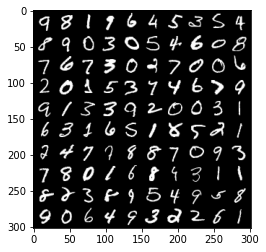

In [63]:
# Save some real images
img, _ = next(iter(train_loader))
img_grid = make_grid(denormalize(img), nrow=10)
save_image(img_grid, os.path.join(images_path , 'real_images.png'))

img = plt.imread(os.path.join(images_path , 'real_images.png'))
plt.imshow(img, cmap='gray')
plt.show()

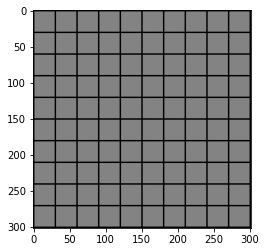

In [64]:
#Save fake images before training
def save_fake_images(idx, test_noise, file_path):
    # test_noise: [batch_size, channels=latent_size, width=1, height=1]
    fake_img = generator(test_noise)
    # fake_img: [batch_size, channels=1, width=28, height=28]
    fake_img_grid = make_grid(denormalize(fake_img).detach().cpu(), nrow=10)

    file_name = "fake_images-{0:0=4d}.png".format(idx)
    save_image(fake_img_grid, os.path.join(file_path, file_name))


test_noise = test_noise = torch.randn([batch_size, latent_size, 1, 1], device=device)
# test_noise: [batch_size, channels=latent_size, width=1, height=1]
idx = 0

save_fake_images(idx, test_noise, images_path)
img = plt.imread(os.path.join(images_path, "fake_images-{0:0=4d}.png".format(idx)))
plt.imshow(img, cmap='gray')
plt.show()

In [65]:
for epoch in range(1, epochs+1):
    mean_g_loss = 0
    mean_d_loss = 0
    for real_img, _ in tqdm(train_loader):
        # real_img: [batch_size, 1, 28, 28]
        real_img = real_img.to(device)

        ####################################
        #           Discriminator          #
        ####################################
        discriminator.train()

        # Loss for real images
        pred_real =  discriminator(real_img)
        target_real = torch.ones_like(pred_real).to(device)
        d_loss_real = criterion(pred_real, target_real)

        # Loss for fake images
        noise_vector = noise_vector = torch.randn([batch_size, latent_size, 1, 1], device=device)
        fake_img = generator(noise_vector)
        pred_fake = discriminator(fake_img.detach())
        target_fake = torch.zeros_like(pred_fake)
        d_loss_fake = criterion(pred_fake, target_fake)

        # Discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2

        # Backprop and optimize
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        ####################################
        #             Generator            #
        ####################################
        generator.train()

        # Loss for fake images
        noise_vector = noise_vector = torch.randn([batch_size, latent_size, 1, 1], device=device)
        fake_img = generator(noise_vector)
        pred = discriminator(fake_img)
        target = torch.ones_like(pred).to(device)
        g_loss = criterion(pred, target)

        # Backprop and optimize
        g_optimizer.zero_grad()
        #d_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Stats
        mean_d_loss += d_loss.item() / len(train_loader)
        mean_g_loss += g_loss.item() / len(train_loader)

    save_fake_images(epoch, test_noise, images_path)

    # Verbose
    print(f"Epoch: {epoch}/{epochs}, g_loss: {mean_g_loss}, d_loss: {mean_d_loss}")

    # Visualization
    if (epoch % 5) == 0:
        img = plt.imread(os.path.join(output_dir, "fake_images-{0:0=4d}.png".format(epoch)))
        plt.imshow(img, cmap='gray')
        plt.show()

100%|██████████| 600/600 [06:38<00:00,  1.51it/s]


Epoch: 1/2, g_loss: 2.527568823198476, d_loss: 0.2239614323930191


100%|██████████| 600/600 [06:25<00:00,  1.56it/s]

Epoch: 2/2, g_loss: 5.186336614688234, d_loss: 0.012065066248954585


## Saving

## Testing


## References

* Generative Adversarial Nets [Goodfellow et al., 2014]: https://arxiv.org/pdf/1406.2661.pdf
* https://www.kaggle.com/vatsalmavani/deep-convolutional-gan-in-pytorch